In [433]:
import os
import re
import nltk
import string
import numpy as np
import contractions
import pandas as pd
import networkx as nx
import multiprocessing
from sklearn import tree
from string import digits
from gensim import corpora
from textblob import TextBlob
from nltk import word_tokenize
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.corpus import wordnet
from wordcloud import WordCloud
import matplotlib.style as style
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve
from matplotlib.ticker import MaxNLocator
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import WordPunctTokenizer
from sklearn.metrics import mean_squared_error
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [381]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download("words")
# nltk.download("stopwords")

In [382]:
def get_files(path):
    return os.listdir(path)

In [383]:
def clean(word):
    word2 = word.translate(re.sub(r'\d+', '', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

In [384]:

delete_words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in delete_words or not w.isalpha())

In [385]:
def isValid(word):
    if len(word) == 2 and word[1] == 'a':
        return False
    return True

In [386]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [387]:
spell = Speller(lang='en')
def clear_document(sentences):
    new_words = ''
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    for sentence in sentences:
        new_words += sentence.strip()
    new_words = clean(new_words)# regexp stemmer (puctuation cleaning)
    tokinezed = word_tokenize(new_words) #tokenization
    tags = nltk.pos_tag(tokinezed) #pos tagging
    correct_sentence = []
    for i in tags:
        position = get_wordnet_pos(i[1])
        if position == '':
            correct_sentence.append(lemmatizer.lemmatize(word=i[0]))  # lemmatization
        else:
            correct_sentence.append(lemmatizer.lemmatize(word=i[0], pos=position))  # lemmatization 
    correct_sentence = [lemmatizer.lemmatize(i) for i in correct_sentence]
    correct_sentence = [spell(i) for i in correct_sentence]
    stop_words = []
    stops = stopwords.words('english') #stop word removal
    [stop_words.append(word.replace("'", '') ) for word in stops]
    stop_words = list(set(stop_words))
    filtered_words = list(map(clean_sent, correct_sentence))
    filtered_words = [word for word in filtered_words if word not in stops and isValid(word)]
    while(True):
        if '' in filtered_words:
            filtered_words.remove('')
        else:
            break
    return ' '.join(filtered_words)

In [388]:
def clean_document(fileName):
    with open(fileName[0]) as f:
        words = f.readlines()
        cleaned_document = clear_document(words)
    with open(fileName[1],"w") as f:
        f.write(cleaned_document)

## We command this part because it takes some time to do cleaning and we already saved cleaned parts

In [389]:
# path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
# path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
# for i in range(2):
#     path = path_list[i]
#     path_2 = path_list_2[i]
#     files = get_files(path)
#     filenames = [(path + file, path_2+file) for file in files]
#     with multiprocessing.Pool(20) as p:
#         # Use the pool to read all the files in parallel
#         p.map(clean_document, filenames)

In [390]:
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
all_documents = []
sentiments = []
for i in range(2):
    path = path_list_2[i]
    files = get_files(path)
    for file in files:
        with open(path+file) as f:
            sentence = f.readline()
        all_documents.append(sentence)
        sentiments.append(path[-4:-1])

In [391]:
df = pd.DataFrame(columns=['text'], data=all_documents)

In [392]:
df['number_of_words'] = df['text'].apply(lambda x : len(TextBlob(str(x)).words))
df['polarity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.subjectivity)
df['number_of_letters'] = df['text'].apply(lambda x: sum([len(i) for i in x.split(' ')]))

In [393]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909
...,...,...,...,...,...
1995,synopsis meteorite desert community college pr...,137,0.119066,0.555123,878
1996,anniversary slaying love best friend still bes...,252,0.148363,0.598198,1400
1997,coincide emerge popularity movie deal anything...,155,0.014219,0.464103,935
1998,highflying hong style make way classic pretty ...,209,-0.047128,0.451001,1202


In [394]:
bag_of_words_model = CountVectorizer(max_features=10)

In [395]:
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
bag_of_word_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,6,2,1,3,2,0,2,1,6,3
1,2,6,3,1,0,4,1,4,1,4
2,1,18,2,2,5,7,7,4,12,7
3,1,4,1,3,2,0,1,6,0,1
4,1,2,0,0,5,2,1,1,1,0


In [396]:
tfidf_model = TfidfVectorizer(max_features=10)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = tfidf_model.get_feature_names_out()
tfidf_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,0.620535,0.171225,0.101604,0.320219,0.217368,0.000000,0.191307,0.092488,0.523057,0.326748
1,0.216574,0.537834,0.319149,0.111760,0.000000,0.415934,0.100153,0.387354,0.091276,0.456156
2,0.044053,0.656394,0.086556,0.090931,0.231469,0.296113,0.285204,0.157581,0.445590,0.324748
3,0.131662,0.435953,0.129347,0.407652,0.276720,0.000000,0.121771,0.706450,0.000000,0.138655
4,0.163510,0.270704,0.000000,0.000000,0.859143,0.314024,0.151228,0.146223,0.137825,0.000000


## We Chose Bag Of Words

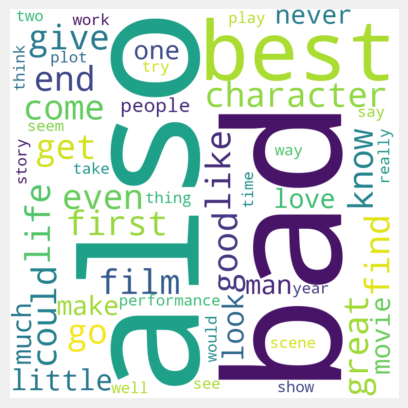

In [397]:
bag_of_words_model = CountVectorizer(max_features=50)
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = bag_of_words_model.get_feature_names_out()
bests2= list(bag_of_word_df.columns)
wordcloud = WordCloud(width = 800, height = 800, 
    background_color ='white', 
    max_words=50,
    stopwords = [],
    min_font_size = 10).generate(' '.join(bests2))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [398]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909
...,...,...,...,...,...
1995,synopsis meteorite desert community college pr...,137,0.119066,0.555123,878
1996,anniversary slaying love best friend still bes...,252,0.148363,0.598198,1400
1997,coincide emerge popularity movie deal anything...,155,0.014219,0.464103,935
1998,highflying hong style make way classic pretty ...,209,-0.047128,0.451001,1202


In [399]:
def plot_roc_curve(test_df, test_label, algorithm_name):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_df['actual_cluster'], test_df[test_label])
    plt.subplots(1, figsize=(10,10))
    plt.title(f'Receiver Operating Characteristic - {algorithm_name}')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [400]:
df['actual_cluster'] = [0 for _ in range(1000)] + [1 for _ in range(1000)]

In [401]:
linreg = LinearRegression()
standard_scaler = StandardScaler()
values = df.drop(['actual_cluster', 'text'], axis=1).values #returns a numpy array
columns = df.drop(['actual_cluster', 'text'], axis=1).columns
x_scaled = standard_scaler.fit_transform(values)
new_df = pd.DataFrame(x_scaled)
new_df.columns = columns
new_df['actual_cluster'] = df['actual_cluster']
train_df, test_df = train_test_split(new_df, test_size =0.3)


linreg.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

test_df['predicted_score_from_linear_regression'] = linreg.predict(test_df.drop('actual_cluster', axis=1))
test_df[['actual_cluster', 'predicted_score_from_linear_regression']]


,actual_cluster,predicted_score_from_linear_regression
391,0,0.590978
1242,1,0.970802
1742,1,0.622732
1729,1,0.520101
1683,1,0.723521
...,...,...
1525,1,0.718464
536,0,0.332086
1522,1,0.598347
1726,1,0.425903


/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

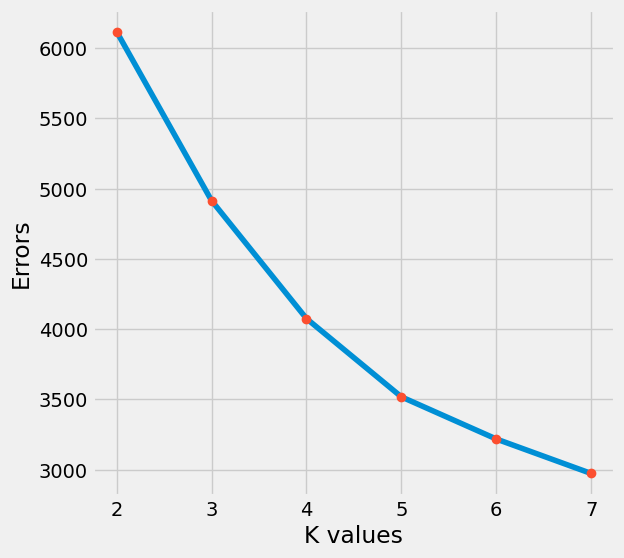

In [421]:
scores=[]
for k in [2,3,4,5,6,7]:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(new_df.to_numpy())
    scores.append(-kmeans.score(new_df.to_numpy()))
plt.figure(figsize=(6, 6))
plt.plot([k for k in range(2,8)], scores)
plt.plot([k for k in range(2,8)], scores, 'o')
plt.xlabel('K values')
plt.ylabel('Errors')
plt.show()

In [403]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(new_df)
y_kmeans = kmeans.predict(new_df)
df['obtained_clusters'] = y_kmeans
print("Root Mean Square Error (RMSE) : ",mean_squared_error(df['actual_cluster'],df['obtained_clusters']))

Root Mean Square Error (RMSE) :  0.568


/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[213, 84], [73, 230]] 443
Root Mean Square Error (RMSE) :  0.17884514091849085
confusion matrix:
 [[213  84]
 [ 73 230]]
Precision: 0.7171717171717171
F1: 0.7307032590051459


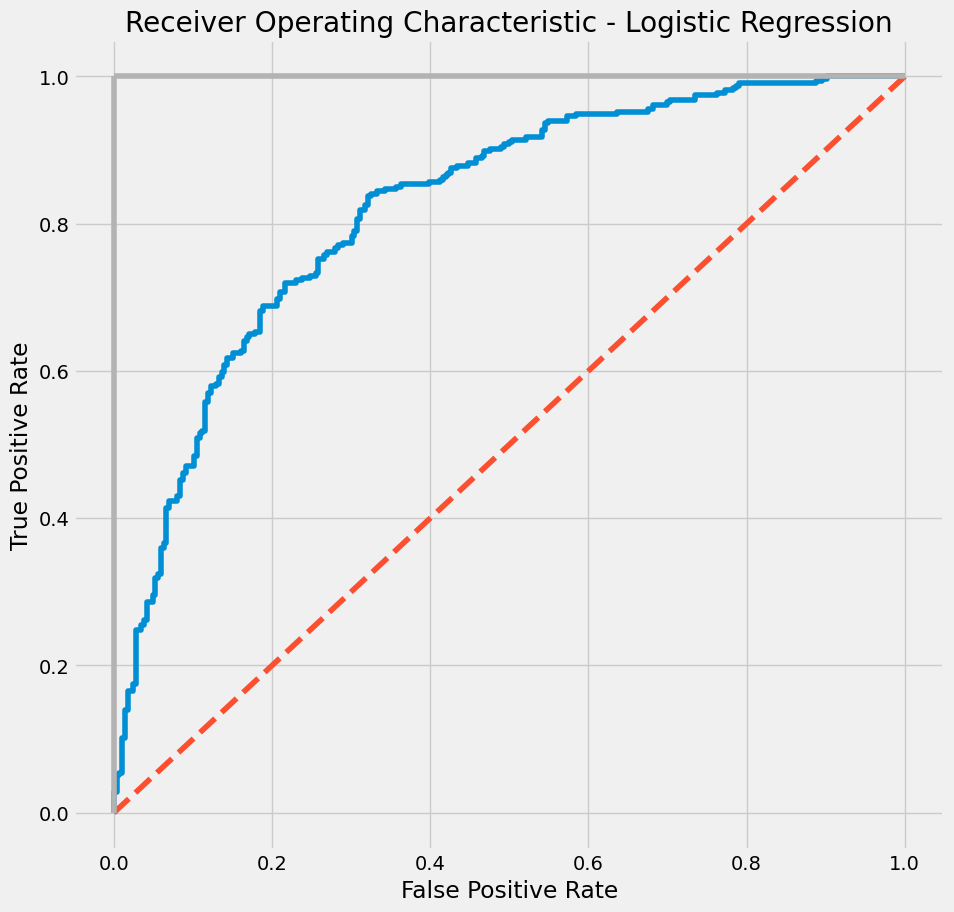

In [404]:
tp_filter = (test_df["actual_cluster"]==0) & (test_df["predicted_score_from_linear_regression"]<0.5)
fn_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted_score_from_linear_regression"]>0.5)
fp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_score_from_linear_regression"]<0.5)
tn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_score_from_linear_regression"]>0.5)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())

print([[tp,fp], [fn,tn]], tp + tn)
print("Root Mean Square Error (RMSE) : ",mean_squared_error(test_df['actual_cluster'],test_df['predicted_score_from_linear_regression']))

print('confusion matrix:\n', np.array([[tp,fp], [fn,tn]]))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=test_df, test_label='predicted_score_from_linear_regression', algorithm_name='Logistic Regression')

In [405]:
max_ = 0
optimal_c = 0
tfidf_df['actual_cluster'] = df['actual_cluster']
train_df, test_df = train_test_split(tfidf_df, test_size =0.3)

for i in [0.01, 0.05, 0.1, 0.5, 1.0, 2, 5, 10, 50, 250]:
    

    logreg = LogisticRegression(C=i,penalty='l2', fit_intercept=True, solver='lbfgs', max_iter=1000, multi_class='auto')
    
    logreg.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

    train_df['predicted_labels_from_LogisticRegression'] = logreg.predict(train_df.drop('actual_cluster', axis=1))
    
    tp_filter = (train_df["actual_cluster"]==0) & (train_df["predicted_labels_from_LogisticRegression"]<0.5)
    fn_filter = (train_df["actual_cluster"]== 0) & (train_df["predicted_labels_from_LogisticRegression"]>0.5)
    fp_filter = (train_df["actual_cluster"]== 1) & (train_df["predicted_labels_from_LogisticRegression"]<0.5)
    tn_filter = (train_df["actual_cluster"]== 1) & (train_df["predicted_labels_from_LogisticRegression"]>0.5)
    
    # filtering data
    tp = len(train_df.where(tp_filter).dropna())
    fp = len(train_df.where(fp_filter).dropna())
    tn = len(train_df.where(tn_filter).dropna())
    fn = len(train_df.where(fn_filter).dropna())

    if(tp+tn > max_):
        max_ = tp+tn
        optimal_c = i



Root Mean Square Error (RMSE) :  0.41833333333333333
confusion matrix:
 [[165 119]
 [132 184]]
Precision: 0.5809859154929577
F1: 0.5679862306368331


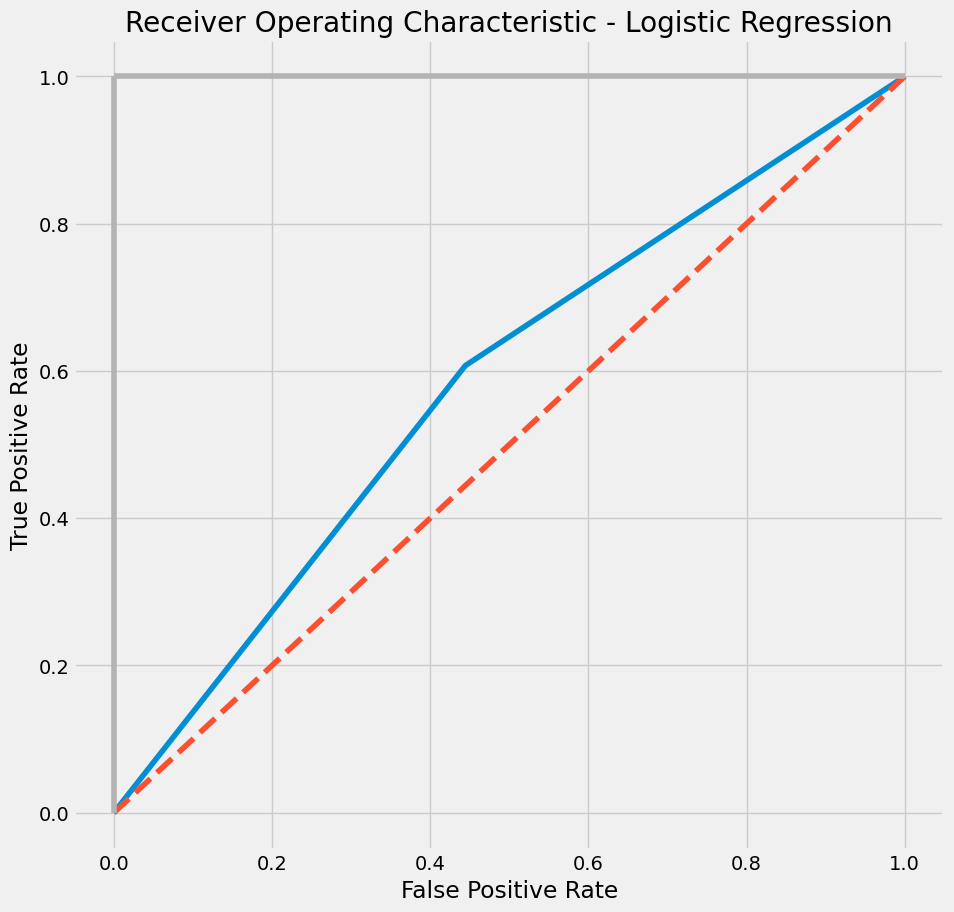

In [406]:

logreg = LogisticRegression(C=optimal_c,penalty='l2', fit_intercept=True, solver='lbfgs', max_iter=1000, multi_class='auto')

logreg.fit(test_df.drop('actual_cluster', axis=1), test_df['actual_cluster'])

test_df['predicted_labels_from_LogisticRegression'] = logreg.predict(test_df.drop('actual_cluster', axis=1))

tp_filter = (test_df["actual_cluster"]==0) & (test_df["predicted_labels_from_LogisticRegression"]<0.5)
fn_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted_labels_from_LogisticRegression"]>0.5)
fp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_labels_from_LogisticRegression"]<0.5)
tn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_labels_from_LogisticRegression"]>0.5)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())

print("Root Mean Square Error (RMSE) : ",mean_squared_error(test_df['actual_cluster'],test_df['predicted_labels_from_LogisticRegression']))
print('confusion matrix:\n', np.array([[tp,fp], [fn,tn]]))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=test_df, test_label='predicted_labels_from_LogisticRegression', algorithm_name='Logistic Regression')

In [407]:
tp,fp,tn,fn = 0,0,0,0
tfidf_df['actual_cluster'] = df['actual_cluster']
train_df, test_df = train_test_split(tfidf_df, test_size =0.3)
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

test_df['predicted'] = dtc.predict(test_df.drop('actual_cluster', axis=1))

Root Mean Square Error (RMSE) :  0.47
confusion matrix:
 [[160 145]
 [137 158]]
Precision: 0.5245901639344263
F1: 0.5315614617940201


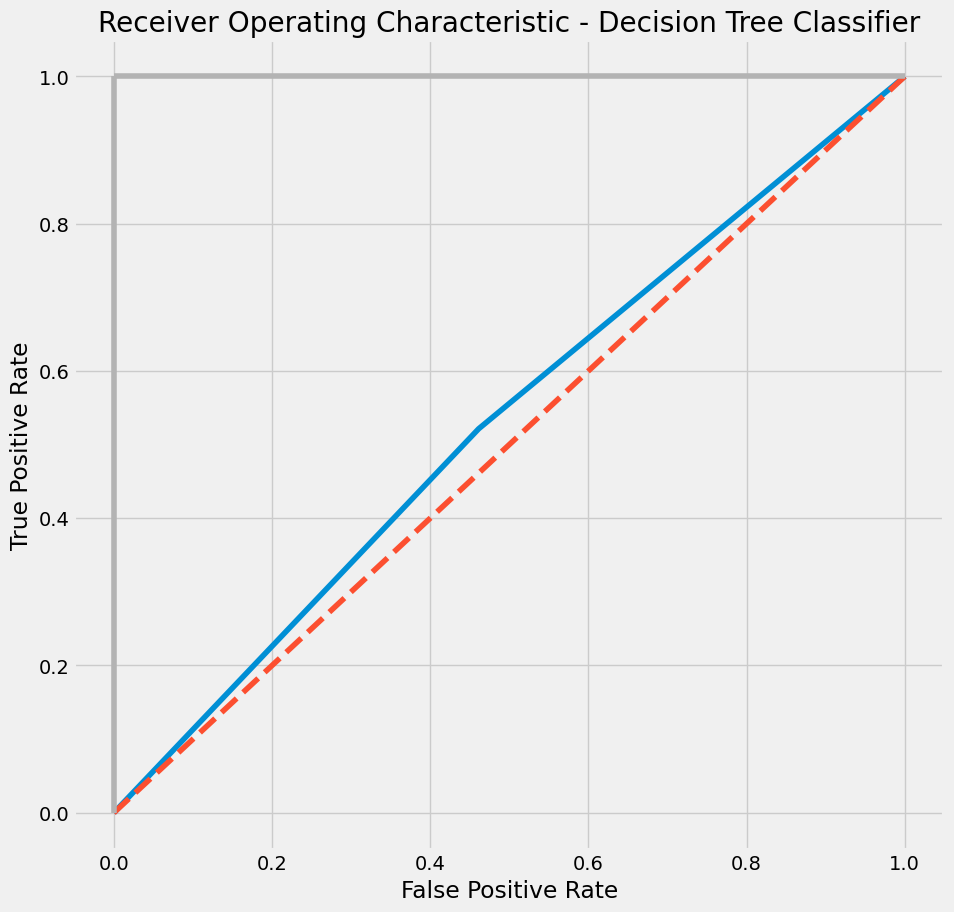

In [408]:
tp_filter = (test_df["actual_cluster"]==0) & (test_df["predicted"]==0)
fn_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted"]== 1)
fp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted"]== 0)
tn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted"]== 1)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())

print("Root Mean Square Error (RMSE) : ",mean_squared_error(test_df['actual_cluster'],test_df['predicted']))
print('confusion matrix:\n', np.array([[tp,fp], [fn,tn]]))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=test_df, test_label='predicted', algorithm_name='Decision Tree Classifier')

In [409]:

df_lda = pd.DataFrame()
df_lda['text'] = df['text']
lists = df_lda.text.apply(word_tokenize).tolist()

In [410]:
dictionary = corpora.Dictionary(lists)
corpus = [dictionary.doc2bow(text) for text in lists]

In [411]:

def calculate_coherence_score(documents, dictionary, model):
    coherence_model = CoherenceModel(model=model,
                                    texts=documents,
                                    dictionary=dictionary,
                                    coherence='c_v')
    return coherence_model.get_coherence()
def get_coherence_values(start, stop):
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics')
        ldamodel = LdaModel(corpus,
                    num_topics = num_topics,
                    id2word=dictionary, passes=2)
        coherence = calculate_coherence_score(lists,
                                            dictionary,
                                            ldamodel)
        yield coherence

In [412]:
min_topics, max_topics = 2,15
coherence_scores = list(get_coherence_values(min_topics, max_topics))


Calculating coherence for 2 topics

Calculating coherence for 3 topics

Calculating coherence for 4 topics

Calculating coherence for 5 topics

Calculating coherence for 6 topics

Calculating coherence for 7 topics

Calculating coherence for 8 topics

Calculating coherence for 9 topics

Calculating coherence for 10 topics

Calculating coherence for 11 topics

Calculating coherence for 12 topics

Calculating coherence for 13 topics

Calculating coherence for 14 topics


Text(0.5, 1.0, 'Coherence Scores')

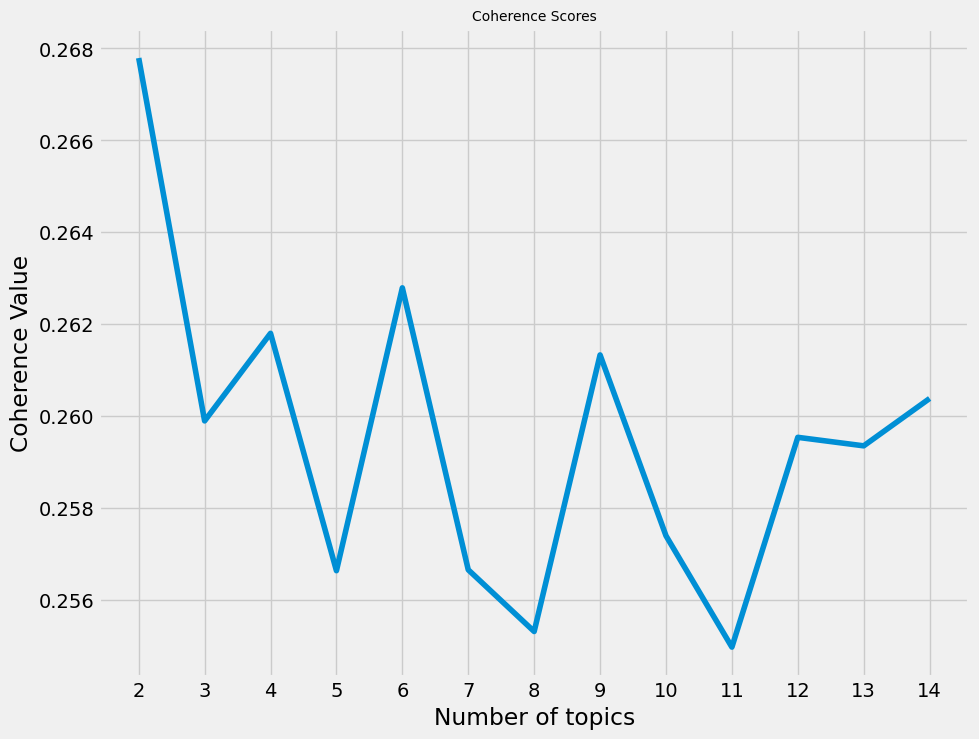

In [413]:
style.use('fivethirtyeight')
%matplotlib inline
x = [int(i) for i in range(min_topics, max_topics)]
ax = plt.figure(figsize=(10,8))
plt.xticks(x)
plt.plot(x, coherence_scores)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize=10)

# 2 is the best for LDA

In [414]:
ldamodel = LdaModel(corpus, num_topics = 2, id2word=dictionary, passes=2)
coherence = calculate_coherence_score(lists, dictionary, ldamodel)

In [415]:
coherence

0.26461842137481806

# Part 4

In [422]:
def cl(word):
    word2 = word.translate(re.sub(r'\d+', '', word).maketrans('', '', string.punctuation)).lower()
    print(word2)
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

In [423]:
CLEAN_PATTERN = r'[^a-zA-z\s]'
stop_words = stopwords.words('english')

def clean(word):
    word2 = word.translate(re.sub(CLEAN_PATTERN,'', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

def clean_sentence(sentence):
    sentence = [clean(word) for word in sentence ]
    sentence = (" ".join(w for w in sentence)).strip()
    sentence = sentence.split(" ")
    return [word for word in sentence ]

def clean_sentences(sentences):
    return [clean_sentence(sentence) for sentence in sentences ]

def lower(sentence):
    return [word.lower() for word in sentence]
    
def remove_stopwords(sentence):
    words = [word for word in sentence if word not in stop_words]
    return [word for word in words]

def tokenize_words(sentences):
    return [word_tokenize(sentence)
              for sentence in sentences]
              
def fix_contractions(sentences):
    return [contractions.fix(sentence) for sentence in sentences]

In [424]:
path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
texts = [[],[]] # pos, neg
for i in range(2):
    path = path_list[i]
    files = os.listdir(path)
    for fileName in files:
        text = ""
        with open(path+fileName) as f:
            text = f.read()
        texts[i].append(text)

In [426]:
pos_df = pd.DataFrame()
neg_df = pd.DataFrame()

pos_df["raw_text"] = texts[0]
neg_df["raw_text"] = texts[1]

In [427]:
pos_df['SentencesInArticle'] = pos_df.raw_text.apply(sent_tokenize)
pos_df['WordsInSentences'] = pos_df.SentencesInArticle \
              .apply(fix_contractions)\
              .apply(lower)\
              .apply(tokenize_words)\
              .apply(remove_stopwords)\
              .apply(clean_sentences)


neg_df['SentencesInArticle'] = neg_df.raw_text.apply(sent_tokenize)
neg_df['WordsInSentences'] = neg_df.SentencesInArticle \
              .apply(fix_contractions)\
              .apply(lower)\
              .apply(tokenize_words)\
              .apply(remove_stopwords)\
              .apply(clean_sentences)

In [428]:
dfs = [pos_df,neg_df]
dfs[0].head()

,raw_text,SentencesInArticle,WordsInSentences
0,assume nothing . \nthe phrase is perhaps one o...,"[assume nothing ., the phrase is perhaps one o...","[[assume, nothing], [the, phrase, is, perhaps,..."
1,plot : derek zoolander is a male model . \nhe ...,"[plot : derek zoolander is a male model ., he ...","[[plot, , derek, zoolander, is, a, male, model..."
2,i actually am a fan of the original 1961 or so...,[i actually am a fan of the original 1961 or s...,"[[i, actually, am, a, fan, of, the, original, ..."
3,a movie that's been as highly built up as the ...,[a movie that's been as highly built up as the...,"[[a, movie, that, is, been, as, highly, built,..."
4,""" good will hunting "" is two movies in one : ...","[ "" good will hunting "" is two movies in one :...","[[good, will, hunting, , is, two, movies, in, ..."


In [429]:
def load_glove_vectors(fn):
    print("Loading Glove Model")
    with open( fn,'r', encoding='utf8') as glove_vector_file:
        model = {}
        for line in glove_vector_file:
            parts = line.split()
            word = parts[0]
            embedding = np.array([float(val) for val in parts[1:]])
            model[word] = embedding
        print("Loaded {} words".format(len(model)))
    return model
glove_vectors = load_glove_vectors('glove.6B/glove.6B.50d.txt')

Loading Glove Model
Loaded 400000 words


In [430]:
VECTOR_SIZE = 50
EMPTY_VECTOR = np.zeros(VECTOR_SIZE)
def sentence_vector(sentence):
    if(len(sentence) == 0):
        return EMPTY_VECTOR
    return sum([glove_vectors.get(word, EMPTY_VECTOR)
                  for word in sentence])/len(sentence)
def sentences_to_vectors(sentences):
    return [sentence_vector(sentence)
              for sentence in sentences]

In [431]:
pos_df['SentenceVector'] = pos_df.WordsInSentences.apply(sentences_to_vectors)
        

neg_df['SentenceVector'] = neg_df.WordsInSentences.apply(sentences_to_vectors)


In [432]:
def similarity_matrix(sentence_vectors):
    sim_mat = np.zeros([len(sentence_vectors), len(sentence_vectors)])
    for i in range(len(sentence_vectors)):
        for j in range(len(sentence_vectors)):
            element_i = sentence_vectors[i].reshape(1,VECTOR_SIZE)
            element_j = sentence_vectors[j].reshape(1,VECTOR_SIZE)
            sim_mat[i][j] = cosine_similarity(element_i,
                                              element_j)[0,0]
    return sim_mat

In [434]:
pos_df['SimMatrix'] =  pos_df.SentenceVector.apply(similarity_matrix)

neg_df['SimMatrix'] =  neg_df.SentenceVector.apply(similarity_matrix)


In [435]:
def compute_graph(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank_numpy(nx_graph)
    return scores

In [436]:
pos_df['Graph'] = pos_df.SimMatrix.apply(compute_graph)

neg_df['Graph'] = neg_df.SimMatrix.apply(compute_graph)

/var/folders/2s/cbfymxys13q9dlvx0vy5djd80000gn/T/ipykernel_97138/1487212534.py:3: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  scores = nx.pagerank_numpy(nx_graph)
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(
/var/folders/2s/cbfymxys13q9dlvx0vy5djd80000gn/T/ipykernel_97138/1487212534.py:3: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  scores = nx.pagerank_numpy(nx_graph)
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


In [437]:
def get_ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s)
                         for i,s in enumerate(sentences)),
                                reverse=True)
    top_n_sentences = [sentence
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

In [438]:
pos_df['Summary'] = pos_df.apply(lambda d:get_ranked_sentences(d.SentencesInArticle,d.Graph), axis=1)

neg_df['Summary'] = neg_df.apply(lambda d:get_ranked_sentences(d.SentencesInArticle,d.Graph), axis=1)


In [439]:

paths = ['summarized_texts/pos_summarized.txt)', 'summarized_texts/neg_summarized.txt']

for i in range(2):
    with open(paths[i],"w") as f:
        for row in range(len(dfs[i])):
            f.write(str(dfs[i].loc[row].Summary) + "\n")

In [440]:
neg_df

,raw_text,SentencesInArticle,WordsInSentences,SentenceVector,SimMatrix,Graph,Summary
0,bad . bad . \nbad . \nthat one word seems to p...,"[bad ., bad ., bad ., that one word seems to p...","[[bad], [bad], [bad], [that, one, word, seems,...","[[-0.17981, -0.40407, -0.1653, -0.60687, -0.39...","[[0.9999999999999999, 0.9999999999999999, 0.99...","{0: 0.013095349419546633, 1: 0.013095349419546...",i had absolutely no idea why the hell that was...
1,isn't it the ultimate sign of a movie's cinema...,[isn't it the ultimate sign of a movie's cinem...,"[[is, not, it, the, ultimate, sign, of, a, mov...","[[0.35053332499999995, 0.12000682142857143, 0....","[[1.0000000000000002, 0.9242768065256571, 0.98...","{0: 0.032640040939886004, 1: 0.030842249800034...","and for the life of me , i can't figure out wh..."
2,""" gordy "" is not a movie , it is a 90-minute-...","[ "" gordy "" is not a movie , it is a 90-minute...","[[gordy, , is, not, a, movie, , it, is, a, min...","[[0.20148833333333335, 0.12275725833333333, -0...","[[0.9999999999999998, 0.9770843715065798, 0.94...","{0: 0.04808792903892193, 1: 0.0481857064427436...","he never raises his voice or becomes angry , a..."
3,disconnect the phone line . \ndon't accept the...,"[disconnect the phone line ., don't accept the...","[[disconnect, the, phone, line], [do, not, acc...","[[0.3992775, 0.08276525, 0.605725, 0.240415, 0...","[[1.0, 0.753896861186128, 0.7576496369568549, ...","{0: 0.02703145486053848, 1: 0.0291172308668215...",`hanging up' has the overall effect of a tele-...
4,when robert forster found himself famous again...,[when robert forster found himself famous agai...,"[[when, robert, forster, found, himself, famou...","[[0.036284666666666694, 0.14256848148148146, -...","[[1.0000000000000002, 0.9296500575662712, 0.95...","{0: 0.03422118530606451, 1: 0.0337982652254301...","and at that point , the only thing i really kn..."
...,...,...,...,...,...,...,...
995,synopsis : when a meteorite crashlands in the ...,[synopsis : when a meteorite crashlands in the...,"[[synopsis, , when, a, meteorite, crashlands, ...","[[0.10417353333333335, 0.19783570000000003, -0...","[[1.0, 0.9302233183276023, 0.9226704442116079,...","{0: 0.0610993014968361, 1: 0.06316737737488075...",duchovny has stunningly little in the way of m...
996,it's now the anniversary of the slayings of ju...,[it's now the anniversary of the slayings of j...,"[[it, is, now, the, anniversary, of, the, slay...","[[0.11585863157894742, 0.4063746842105263, -0....","[[0.9999999999999997, 0.9206555008382328, 0.91...","{0: 0.02856442839210474, 1: 0.0296208778830986...","but the body count soon starts to rise , and f..."
997,coinciding with the emerging popularity of mov...,[coinciding with the emerging popularity of mo...,"[[coinciding, with, the, emerging, popularity,...","[[0.2360011623076923, 0.030823620512820532, 0....","[[1.0, 0.9501176759901878, 0.9170857477092741,...","{0: 0.08252646657517194, 1: 0.0844861113835730...","relentless 3 , third in the row , features sam..."
998,and now the high-flying hong kong style of fil...,[and now the high-flying hong kong style of fi...,"[[and, now, the, highflying, hong, kong, style...","[[0.20751565217391307, 0.027864186956521736, -...","[[1.0, 0.9688613185802831, 0.9534957141533491,...","{0: 0.056341575813670663, 1: 0.056596906522537...",this time out the nod to asia goes by way of f...
